<a href="https://colab.research.google.com/github/shoaibkhanz/my_DataScientist_nanodegree/blob/master/Stackoverflow_annual_developer_survey_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stack Overflow Annual Developer Survey 2019

> Stack Overlow is where everyone goes to get help. It is driven by the community of developers to help the community back.They conduct a survey every year and record all the information about the community and ofcourse the respondent's personal identifiable information is hidden. In 2019 they did it again, their website says the following.

*'with nearly 90,000 responses fielded from over 170 countries and dependent territories, our 2019 Annual Developer Survey examines all aspects of the developer experience from career satisfaction and job search to education and opinions on open source software.'*


### Objective

From a data such as this, we can ask so many questions. However, I am going to keep it simple for this one and try to answer just **3** simple ones. 

**CAUTION:** For all the questions I ask I am going to assume that the survey users are representative of all the stackoverflow users, this assumption should hold true in general.

**Please also follow the Medium blog post to aid your understanding of the analysis done here.**
1. Who are the users of Stackoverflow in **2019** ?
2. How soon can one start contributing to **opensource** ?
3. People who contribute to opensource, do they **earn more** ?  

### Get to know your data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno #to visualise missing data
%matplotlib inline

In [0]:
survey2019 = pd.read_csv('/content/drive/My Drive/developer_survey_data/survey_results_public.csv',encoding = "utf-8")

In [4]:
survey2019.head()

,Respondent,MainBranch,Hobbyist,OpenSourcer,OpenSource,Employment,Country,Student,EdLevel,UndergradMajor,EduOther,OrgSize,DevType,YearsCode,Age1stCode,YearsCodePro,CareerSat,JobSat,MgrIdiot,MgrMoney,MgrWant,JobSeek,LastHireDate,LastInt,FizzBuzz,JobFactors,ResumeUpdate,CurrencySymbol,CurrencyDesc,CompTotal,CompFreq,ConvertedComp,WorkWeekHrs,WorkPlan,WorkChallenge,WorkRemote,WorkLoc,ImpSyn,CodeRev,CodeRevHrs,...,DatabaseWorkedWith,DatabaseDesireNextYear,PlatformWorkedWith,PlatformDesireNextYear,WebFrameWorkedWith,WebFrameDesireNextYear,MiscTechWorkedWith,MiscTechDesireNextYear,DevEnviron,OpSys,Containers,BlockchainOrg,BlockchainIs,BetterLife,ITperson,OffOn,SocialMedia,Extraversion,ScreenName,SOVisit1st,SOVisitFreq,SOVisitTo,SOFindAnswer,SOTimeSaved,SOHowMuchTime,SOAccount,SOPartFreq,SOJobs,EntTeams,SOComm,WelcomeChange,SONewContent,Age,Gender,Trans,Sexuality,Ethnicity,Dependents,SurveyLength,SurveyEase
0,1,I am a student who is learning to code,Yes,Never,The quality of OSS and closed source software ...,"Not employed, and not looking for work",United Kingdom,No,Primary/elementary school,NaN,"Taught yourself a new language, framework, or ...",NaN,NaN,4,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,SQLite,MySQL,MacOS;Windows,Android;Arduino;Windows,Django;Flask,Flask;jQuery,Node.js,Node.js,IntelliJ;Notepad++;PyCharm,Windows,I do not use containers,NaN,NaN,Yes,"Fortunately, someone else has that title",Yes,Twitter,Online,Username,2017,A few times per month or weekly,Find answers to specific questions;Learn how t...,3-5 times per week,Stack Overflow was much faster,31-60 minutes,No,NaN,"No, I didn't know that Stack Overflow had a jo...","No, and I don't know what those are",Neutral,Just as welcome now as I felt last year,Tech articles written by other developers;Indu...,14.0,Man,No,Straight / Heterosexual,NaN,No,Appropriate in length,Neither easy nor difficult
1,2,I am a student who is learning to code,No,Less than once per year,The quality of OSS and closed source software ...,"Not employed, but looking for work",Bosnia and Herzegovina,"Yes, full-time","Secondary school (e.g. American high school, G...",NaN,Taken an online course in programming or softw...,NaN,"Developer, desktop or enterprise applications;...",NaN,17,NaN,NaN,NaN,NaN,NaN,NaN,I am actively looking for a job,I've never had a job,NaN,NaN,Financial performance or funding status of the...,"Something else changed (education, award, medi...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,MySQL,Windows,Windows,Django,Django,NaN,NaN,Atom;PyCharm,Windows,I do not use containers,NaN,Useful across many domains and could change ma...,Yes,Yes,Yes,Instagram,Online,Username,2017,Daily or almost daily,Find answers to specific questions;Learn how t...,3-5 times per week,Stack Overflow was much faster,11-30 minutes,Yes,A few times per month or weekly,"No, I knew that Stack Overflow had a job board...","No, and I don't know what those are","Yes, somewhat",Just as welcome now as I felt last year,Tech articles written by other developers;Indu...,19.0,Man,No,Straight / Heterosexual,NaN,No,Appropriate in length,Neither easy nor difficult
2,3,"I am not primarily a developer, but I write co...",Yes,Never,The quality of OSS and closed source software ...,Employed full-time,Thailand,No,"Bachelor’s degree (BA, BS, B.Eng., etc.)",Web development or web design,"Taught yourself a new language, framework, or ...",100 to 499 employees,"Designer;Developer, back-end;Developer, front-...",3,22,1,Slightly satisfied,Slightly satisfied,Not at all confident,Not sure,Not sure,"I’m not actively looking, but I am open to new...",1-2 years ago,Interview with people in peer roles,No,"Languages, frameworks, and other technologies ...",I was preparing for a job search,THB,Thai baht,23000.0,Monthly,8820.0,40.0,There's no schedule or spec; I work on what se...,Distracting work environment;Inadequate access...,Less than once per month / Never

We must also read the **description** file that helps us understand variable we are trying to explore.

Thus below I **create a function** that returns the description of the column.

In [0]:
survey2019_schema = pd.read_csv('/content/drive/My Drive/developer_survey_data/survey_results_schema.csv')

def get_description(feature_name):
    '''
    input: enter feature name from the data
    output: return the description of the feature    
    
    '''
    print(survey2019_schema[survey2019_schema['Column']==feature_name]['QuestionText'].values[0])
    

In [6]:
#test the get_description function
get_description('Respondent')

Randomized respondent ID number (not in order of survey response time)


In [7]:
print('The Survey 2019 data contains : ')
print(' observations: ',survey2019.shape[0],'\n','features: ',survey2019.shape[1])

The Survey 2019 data contains : 
 observations:  88883 
 features:  85


In [8]:
#data types
survey2019.dtypes.value_counts()

object     79
float64     5
int64       1
dtype: int64

### Visually inspecting for missing values
This is just a visual way to imagine the data. However, it helps us to understand how values are missing for each observations and helps get an understanding of the scale of missing values, but this is not enough we must further look at the missing values to quantify them.

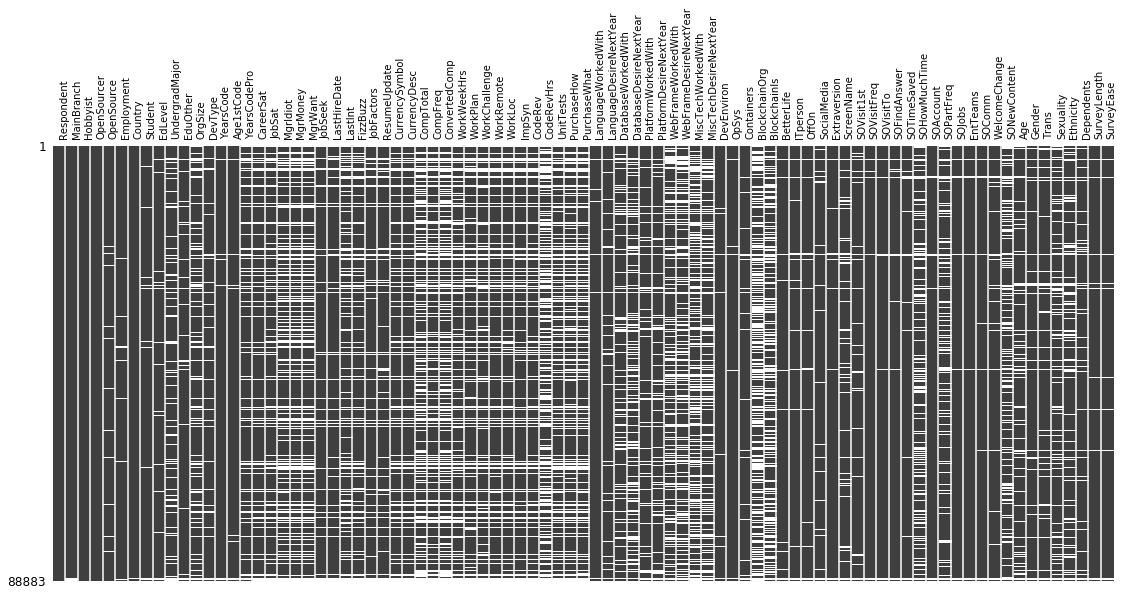

In [9]:
_ = msno.matrix(survey2019, labels = True,fontsize = 10,figsize = (19,8),  sparkline=False) 
plt.xticks(rotation = 90)
plt.show()

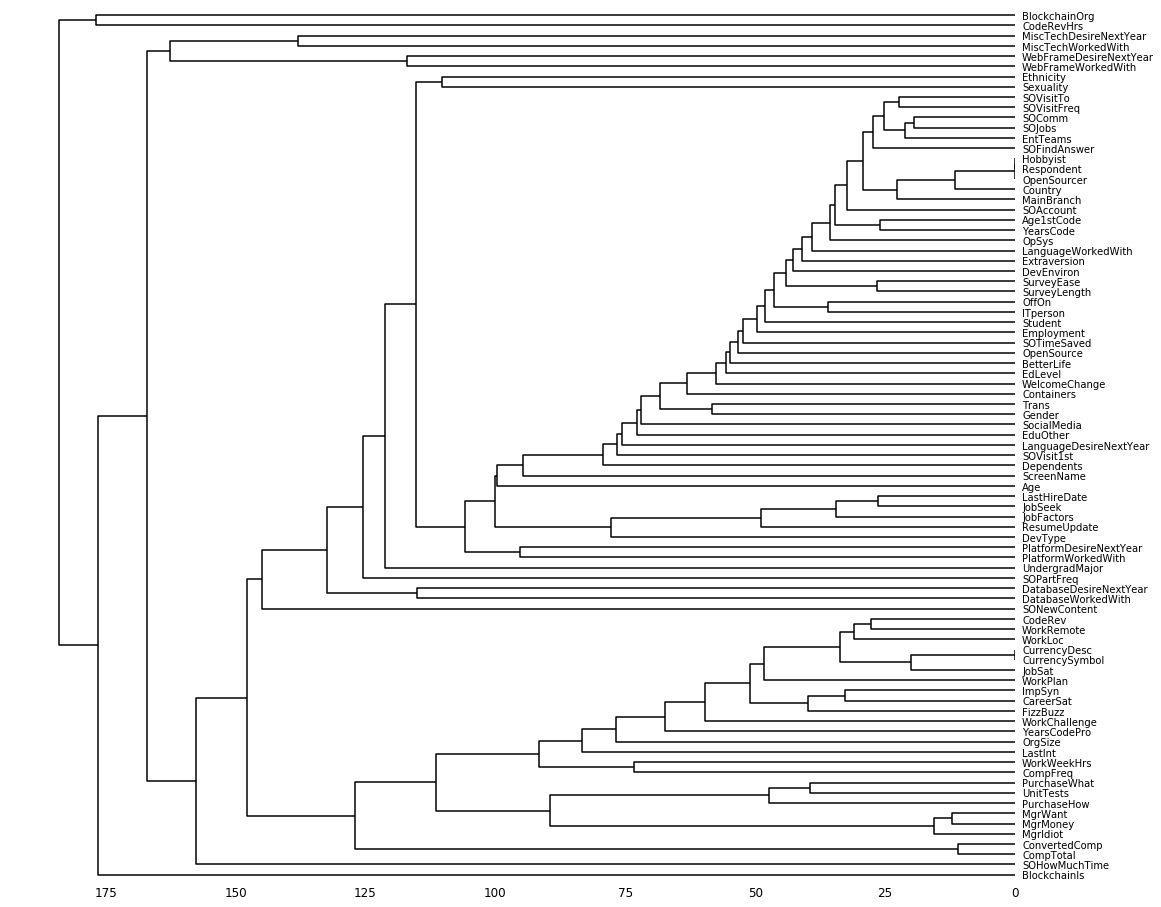

In [10]:
_ = msno.dendrogram(survey2019,fontsize = 10,figsize = (18,16))
plt.show()

From the below bar graph, we know that there are lot of missing values in some of the features like `BlockchainOrg` and `CodeRevHrs` etc.
There are atleast ~50% of features where more than 10% of data is missing. Besides some missing values, I believe we will see some spurios infromation as well and you must not be surprised as this is the case with many surveys.

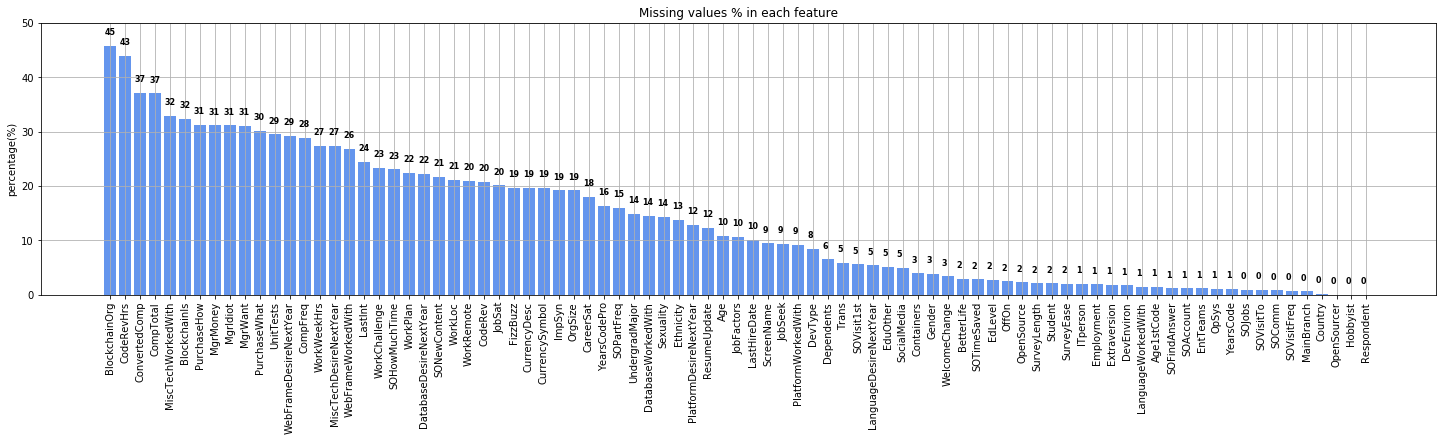

In [11]:
ismissing = survey2019.isnull().sum()
sum(ismissing[ismissing != 0])
ismissing = ismissing/len(survey2019)*100
ismissing.sort_values(ascending=False,inplace=True)

#plotting bar chart of missing values

fig,ax = plt.subplots(figsize=(25,5))
ax.bar(ismissing.index,ismissing.values,color = 'cornflowerblue')
ax.tick_params(axis = 'x',rotation = 90)
ax.set_ylabel('percentage(%)')
ax.set_ylim(top=50)
ax.grid(True)
ax.set_title('Missing values % in each feature')

for i, v in enumerate(ismissing.values):
    ax.text(i - 0.4,v + 2, str(int(v)), color='black',fontsize = 8,fontweight='bold')

plt.show()

### Question 1: Who are the users of Stackoverflow in 2019 ?

I looked at age, gender, user's age when they first coded and programming languages user's use. I believe they should help us to understand the diversity of users that come to stack overflow to seek and give help.

First we must create a **function** to plot continous data as we will be exploring a few continous features in this analysis. The function will help us follow the principles of DRY(Dont repeat yourself), thus I am saving myself some time and maintaining clean code. 

If you follow the histogram for age ranges below, you would see that they range from `1 year to 99 years`, thus I fear this means that some values in age variable may be spurious. However, it is difficult ascertain if the top bound is wrong i.e. `99 years`, may be there are some prople coding away near 100. However, I can definitely say that age `1 year to 3 years` is doubtful (surprise me!). There are `29` such values so I am going to drop them. The `mean age` of users coming to Stackoverflow is around **30 years** and it looks like people from all age groups are contributing and using stackoverflow.

### **Age**

In [12]:
#the following observations will be dropped
print(' Dropping observations:',survey2019[survey2019['Age']<=3].shape,'\n',
      'Dropping null observations',survey2019['Age'].isnull().sum())


 Dropping observations: (29, 85) 
 Dropping null observations 9673


In [13]:
#dropping spurious observations here
print('Before dropping',survey2019.shape)
survey2019 = survey2019[survey2019['Age']>3].reset_index() #this way we are dropping nulls and as well as age 1 to 3
print('After dropping',survey2019.shape)

Before dropping (88883, 85)
After dropping (79181, 86)


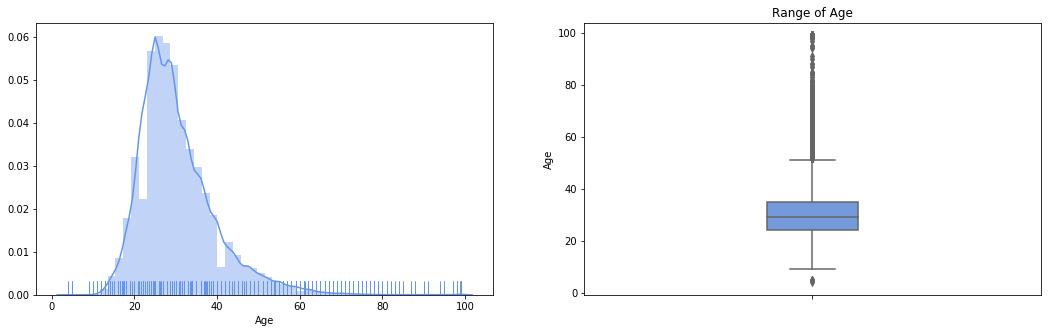

,Age
count,79181.000000
mean,30.347266
std,9.163433
min,4.000000
25%,24.000000
50%,29.000000
75%,35.000000
max,99.000000


In [14]:
def plot_continous_feat(df,feat,rug = True,kde = True):
    
    '''
    input: dataframe and continous feature name (not for discrete feature)
    output: histogram nd boxplot for the continous variable 
    
    '''
    
    df_ = df[feat].dropna().astype(float)
    fig,(ax1,ax2) = plt.subplots(1,2,figsize=(18,5))
    sns.distplot(df_,rug = rug,kde=kde,ax=ax1,color = 'cornflowerblue')
    plt.title('Distribution of '+feat)
    
    _ = sns.boxplot(df_,width = 0.2,orient = 'v',ax=ax2,color = 'cornflowerblue')
    #plt.figtext(0.95,0.5, round(df_.describe(),2).to_string())
    plt.title('Range of '+feat)
    
    plt.show()
    df_show = pd.DataFrame(df_.describe())
    return df_show

#plotting histogram and a boxplot
plot_continous_feat(survey2019,'Age')

### **Gender**

Here I am plotting `gender` but before I do that I have to do some cleaning. I have a written a `casewhen_gender` function which does exactly that, it cleans! In the fuction, I have segmented the gender into `Man`, `Woman` and `others`.

In [0]:
def casewhen_gender(feat):
    '''
    input: dataframe and the gender column
    output: return new categories
    '''
    
    if feat in ['Man']:
        return str('Man')
    elif feat in  ['Woman']:
        return str('Woman')
    else:
        return str('Others')

survey2019['Gender_new'] = survey2019['Gender'].apply(casewhen_gender)

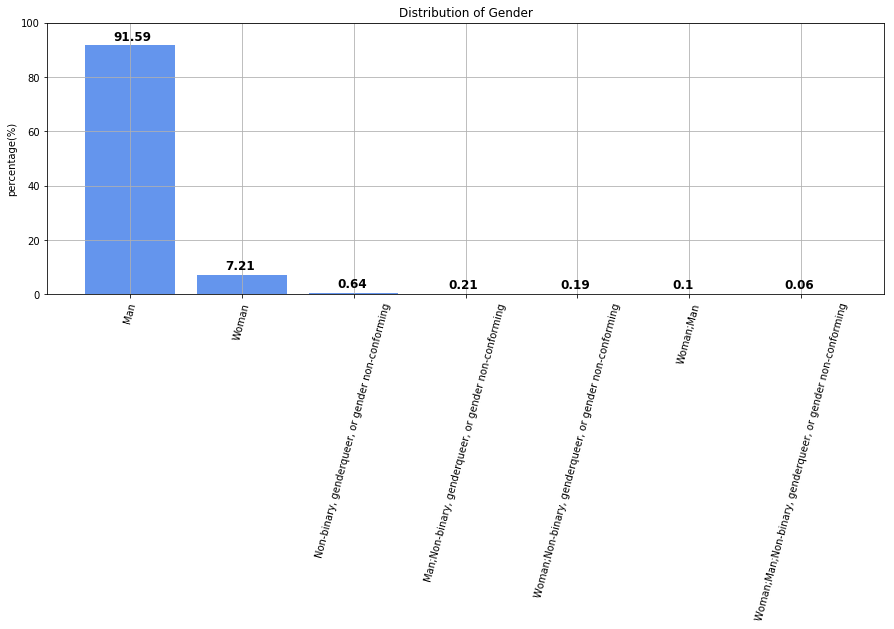

,Gender
Man,71549
Woman,5634
"Non-binary, genderqueer, or gender non-conforming",499
"Man;Non-binary, genderqueer, or gender non-conforming",164
"Woman;Non-binary, genderqueer, or gender non-conforming",146
Woman;Man,81
"Woman;Man;Non-binary, genderqueer, or gender non-conforming",47


In [61]:
def plot_bar(df,feat,normalize = True):
    fig,ax= plt.subplots(figsize = (15,5))
    df_plot = df[feat].value_counts(normalize = normalize)*100
    ax.bar(df_plot.index,df_plot.values,color = 'cornflowerblue')
    ax.set_title('Distribution of '+feat)
    ax.tick_params(axis = 'x',rotation = 75)
    ax.set_ylabel('percentage(%)')
    ax.set_ylim(top=100)
    ax.grid(True)
    
    for i, v in enumerate(df_plot.values):
      ax.text(i-0.15 ,v + 2, str(round(v,2)), color='black',fontsize = 12,fontweight='bold')

    plt.show() 

    df_ = pd.DataFrame(df[feat].value_counts())
    return df_

plot_bar(survey2019,'Gender')

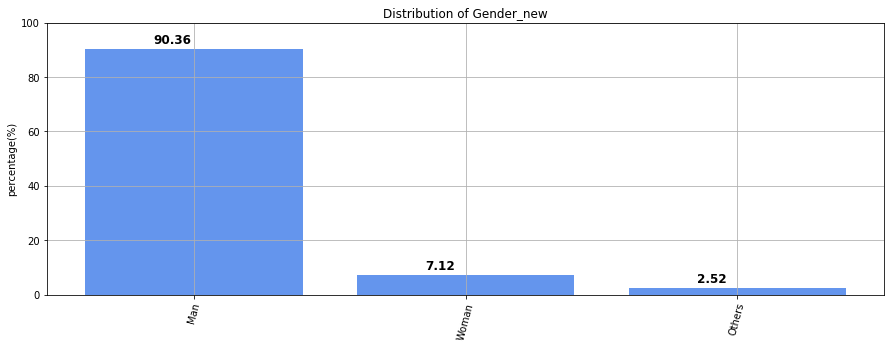

,Gender_new
Man,71549
Woman,5634
Others,1998


In [62]:
#plotting bar chart with cleaned gender variable
plot_bar(survey2019,'Gender_new')

### **First lines of code**

We now look at the `Age1stCode` which represents how soon people have started coding, I had to do some cleaning here as at some places as there were strings in some values. After we have cleaned the data we see that users starts coding as early as, when they are 5 years or as late as 85 years old. This blows my mind, Its pretty incredible to see how diverse age group we have when it comes to coding.

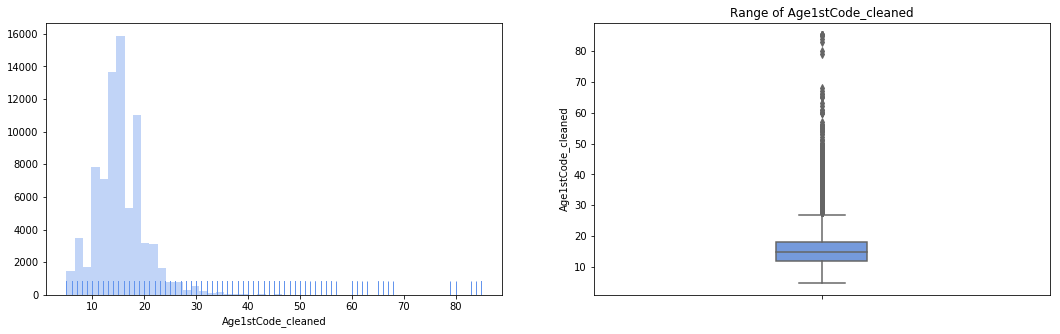

,Age1stCode_cleaned
count,78845.000000
mean,15.355977
std,5.016474
min,5.000000
25%,12.000000
50%,15.000000
75%,18.000000
max,85.000000


In [63]:
survey2019['Age1stCode_cleaned'] = survey2019['Age1stCode'].str.extract('(\d+)').astype(float)
plot_continous_feat(survey2019,'Age1stCode_cleaned',kde = False)

### **Programming Languages**

The next thing we look at are the programming languages that people use. The survey contained this data separated by semicolon. Once again I had to do a bit of cleaning in order to visualise the programming languages that users use. We notice in graphs below thats its actually `Javascript` and `HTML/CSS` that are at the top of the rank and they both represent web and I hope you are not suprised to see them there. In the second place we start seeing languages that support data analytics/science. i.e. `SQL` followed by `Python` which in recent years is not only being used in software engineering but also in data science. `Java` seem to have come down in its ranking as published [here.](https://spectrum.ieee.org/static/interactive-the-top-programming-languages-2019) 

In [0]:
#first 5 examples of LanguageWorkedWith
list(survey2019['LanguageWorkedWith'])[:10]


['HTML/CSS;Java;JavaScript;Python',
 'C++;HTML/CSS;Python',
 'HTML/CSS',
 'C;C++;C#;Python;SQL',
 'C++;HTML/CSS;Java;JavaScript;Python;SQL;VBA',
 'Java;R;SQL',
 'HTML/CSS;JavaScript',
 'Bash/Shell/PowerShell;C;C++;HTML/CSS;Java;JavaScript;Python;SQL',
 'Bash/Shell/PowerShell;C#;HTML/CSS;JavaScript;Python;Ruby;Rust;SQL;TypeScript;WebAssembly;Other(s):',
 'Other(s):']

In [0]:
#cleaning the LanguageWorkedWith column and assigning the cleaned version to 
survey2019['LanguageWorkedWith_cleaned'] = survey2019['LanguageWorkedWith'].fillna('Others')
split_ = []
for i in range(len(survey2019)):
    split_.extend(survey2019['LanguageWorkedWith_cleaned'][i].split(';'))
    
    

In [0]:
from collections import Counter
languages_ = pd.DataFrame.from_dict(Counter(split_),orient='index')
languages_.columns = ['frequency']
languages_.sort_values(by = 'frequency',ascending = False,inplace = True)

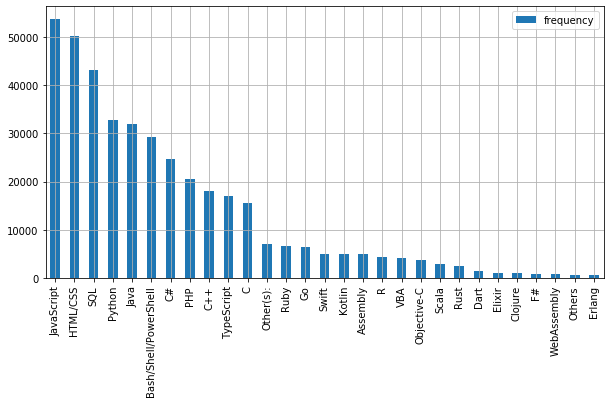

In [0]:
_ = languages_.plot(kind = 'bar',figsize = (10,5))
plt.grid(True)

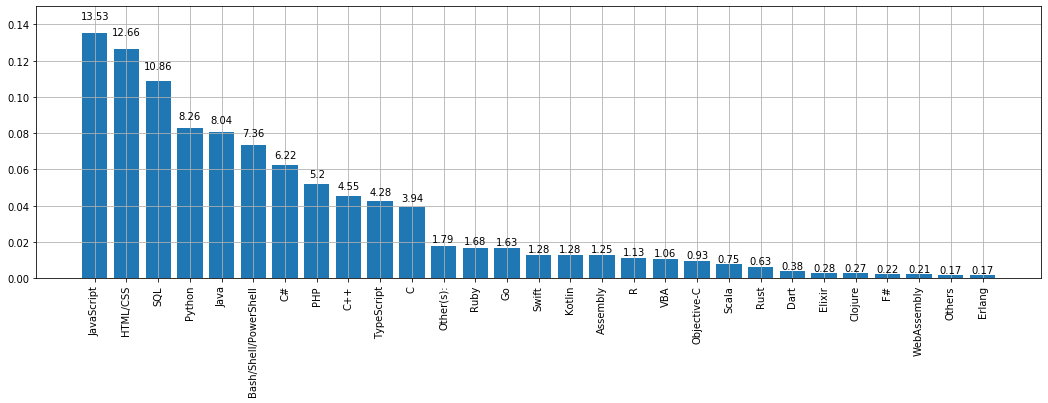

In [0]:
languages_['proportion'] = languages_['frequency']/languages_['frequency'].sum()
languages_.sort_values(by = 'proportion',ascending = False,inplace = True)
fig, ax = plt.subplots(figsize = (18,5))
rects = ax.bar(languages_.index,languages_['proportion'])
ax.tick_params(axis='x', rotation=90)
ax.set_ylim([0, 0.15])
ax.grid(True)
def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%s' % round(height*100,2),
        ha='center', va='bottom')
autolabel(rects)        
plt.show()



In summary, stackoverflow users can be as young as 4 years old or as old as 100. Coding has no age restriction, thus no matter how old one is, once shouldnt shrug away from trying to code. We also saw that woman's share as users is very low but we also know that its changing quite rapidly by efforts like `RLadies` and `DjangoGirls`. People love working with Javascript,Python,Java but suprisingly R isnt there in the top 10.

### Question 2: How soon can one start contributing to **opensource** ?

To answer this question we need to ask few more questions.
* What is the age group of people who contribute to open source ?
* Are there students who contribute to opensource or is it just the professionals ?
* Whats the level of education of opensource contributers ?
* How much time opensource contributers devote to coding ?

### **Opensource**

From the plot below, we can see that roughly 36% of people have never contributed to open source, while around 28% of users are inactive users because they dont contribute every year. If I summarise I would say around 66% of users have contributed to opensource and that is a very large number of people.

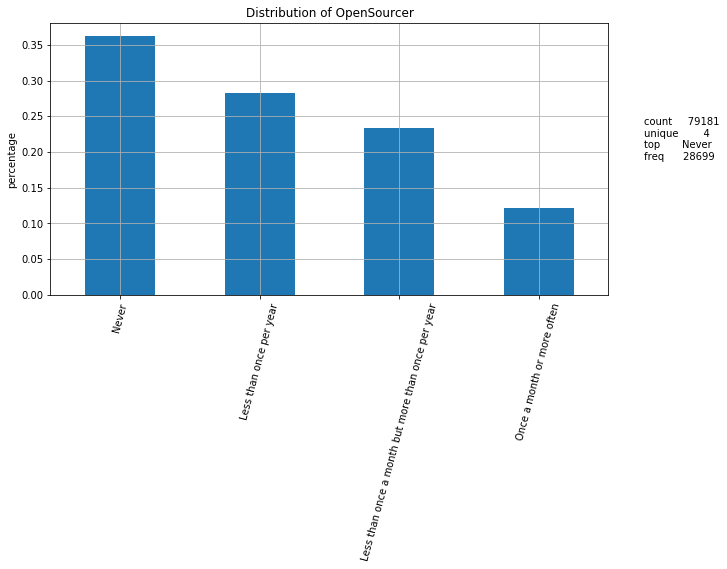

In [0]:
plot_bar(survey2019,'OpenSourcer')

### **Opensource with Age**

Lets look at age distribution among the people who contribute to open source. The one thing that strikes out is once again there are young children and older people who contribute to open source but their number is extremely tiny. If we further look at the age group we see that users with age `10-20` are also contributing which is brilliant for the community, as they start early and perhaps will continue to contribute as they mature. However, we need to look at how much people who contribute to opensource code in general..

In [0]:
opensource_only = survey2019[survey2019['OpenSourcer']!= 'Never']
opensource_only['age_bin'] = pd.cut(opensource_only['Age'],[0,10,20,30,60,80,100],labels=['0-10','10-20','20-30','30-60','60-80','80-100'])
opensourcer_ = opensource_only.groupby(['age_bin','OpenSourcer'])['Respondent'].count()
opensourcer_perc_ = opensourcer_.div(opensourcer_.sum())

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


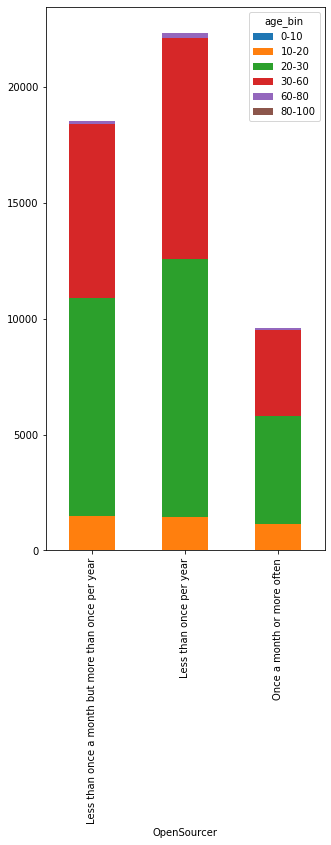

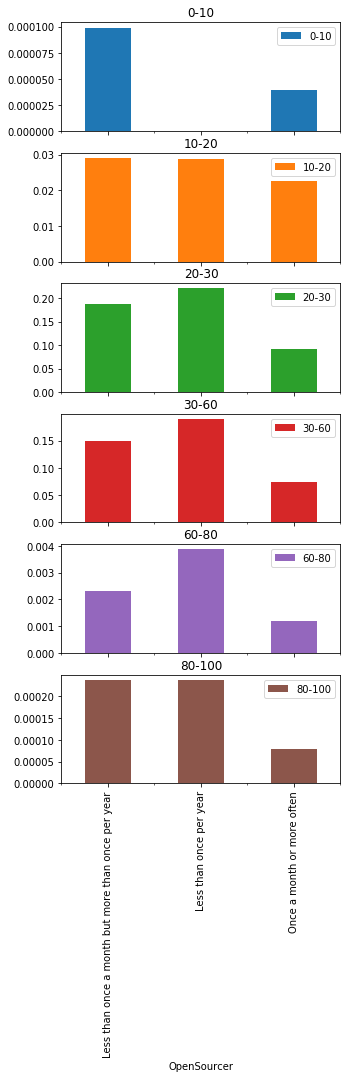

In [0]:
_ = opensourcer_.unstack(level=0).plot(kind='bar', stacked = True,figsize=(5,10))
_ = opensourcer_perc_.unstack(level=0).plot(kind='bar', subplots = True,figsize=(5,14))


### **Opensource and First lines of code**

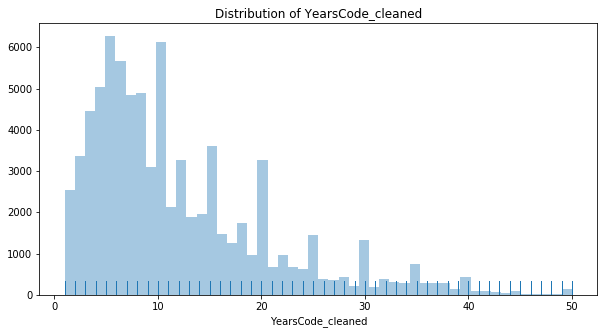

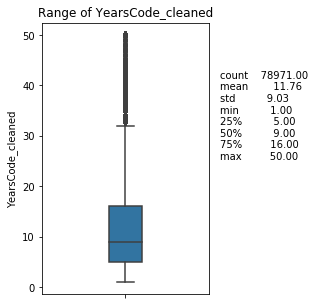

In [0]:
survey2019['YearsCode_cleaned'] = survey2019['YearsCode'].str.extract('(\d+)').astype(float)
plot_continous_feat(survey2019,'YearsCode_cleaned',kde = False)

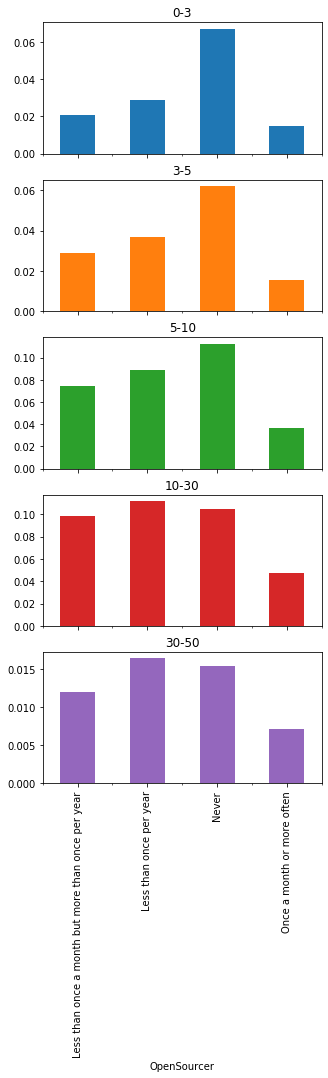

In [0]:
survey2019['YearsCode_bin'] = pd.cut(survey2019['YearsCode_cleaned'],[0,3,5,10,30,50],labels=['0-3','3-5','5-10','10-30','30-50'])
coding_ops_ = survey2019.groupby(['YearsCode_bin','OpenSourcer'])['Respondent'].count()

coding_ops_perc_ = coding_ops_.div(coding_ops_.sum())
_ = coding_ops_perc_.unstack(level=0).plot(kind='bar', subplots = True,figsize=(5,14),legend = False)

### **Students**

Overall, There are 23% of students in the data and split between students is 75% fulltime and 25% part time

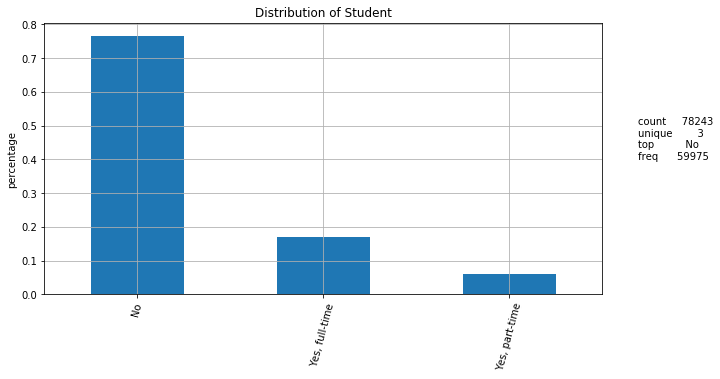

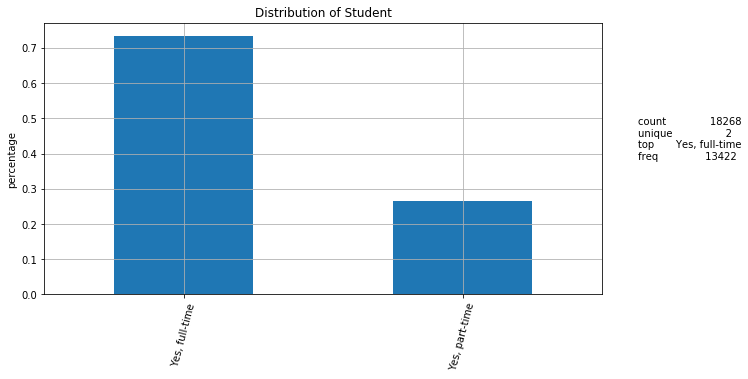

In [0]:
students_ = survey2019[survey2019['Student']!= 'No']
plot_bar(survey2019,'Student')
plot_bar(students_,'Student')

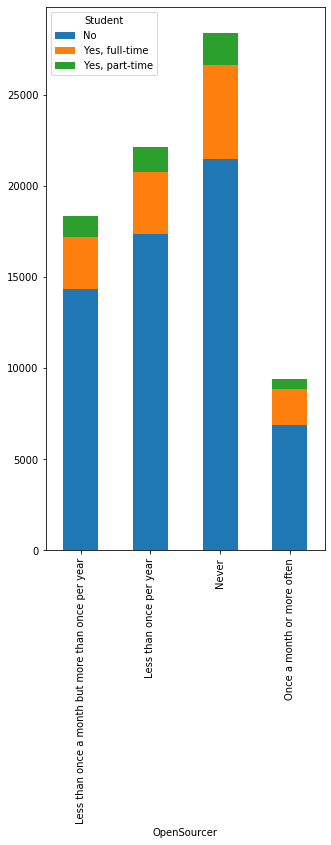

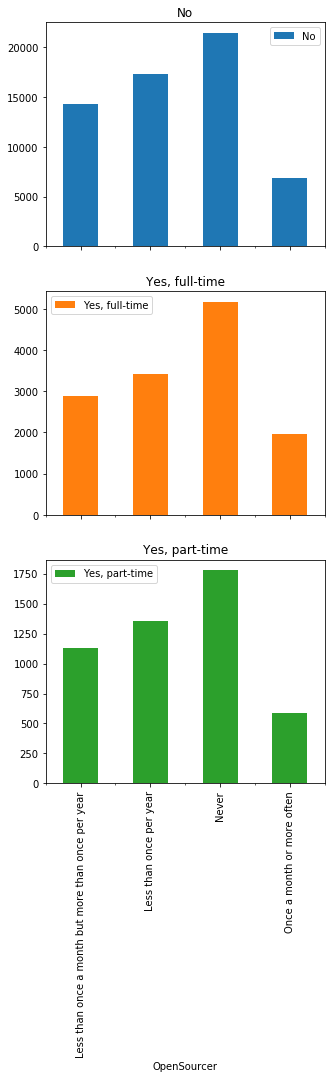

In [0]:
student_ops_ = survey2019.groupby(['Student','OpenSourcer'])['Respondent'].count()
student_ops_perc = student_ops_.div(student_ops_.sum())
_ = student_ops_.unstack(level=0).plot(kind='bar', stacked = True,figsize=(5,10))
_ = student_ops_.unstack(level=0).plot(kind='bar', subplots = True,figsize=(5,14))



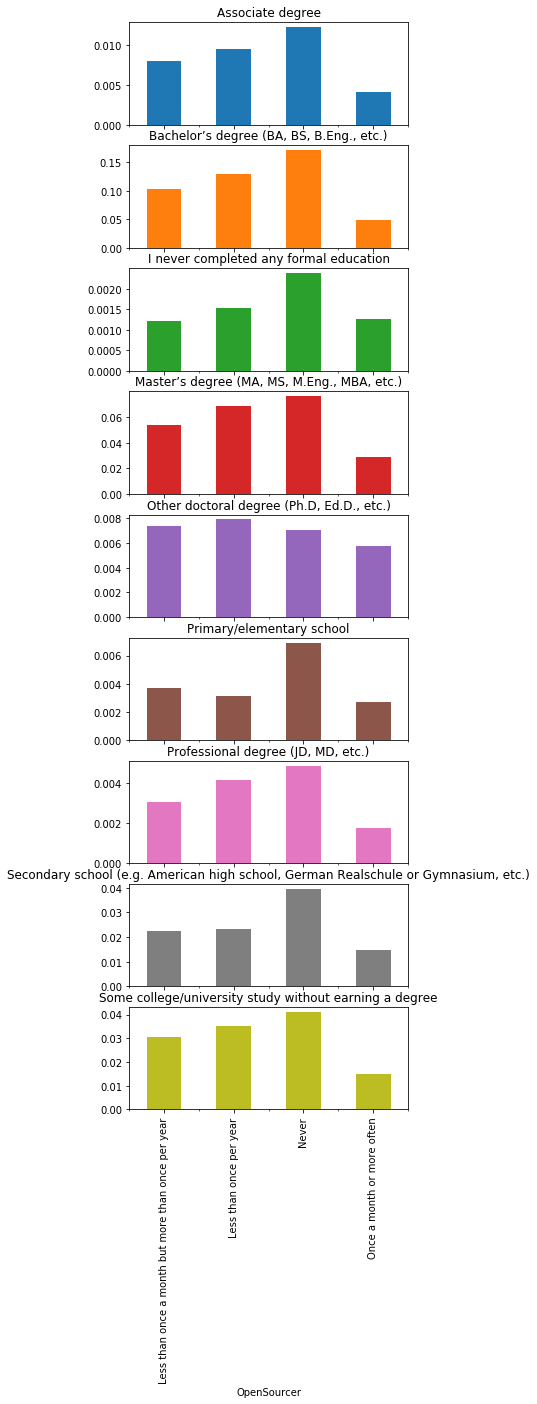

In [0]:
ed_ops_ = survey2019.groupby(['EdLevel','OpenSourcer'])['Respondent'].count()
ed_ops_perc_ = ed_ops_.div(ed_ops_.sum())
_ = ed_ops_perc_.unstack(level=0).plot(kind='bar', subplots = True,figsize=(5,20),legend = False)

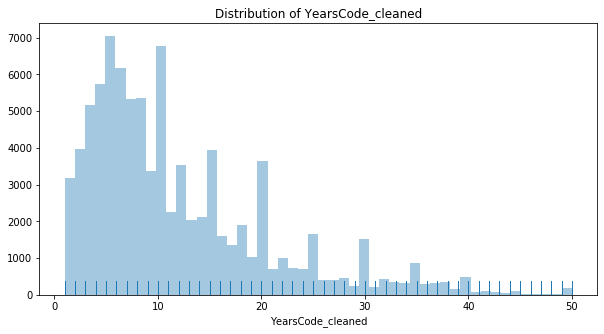

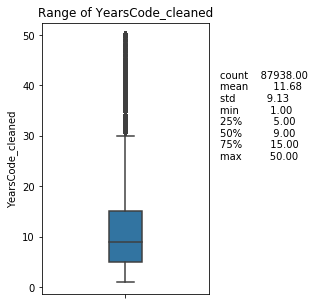

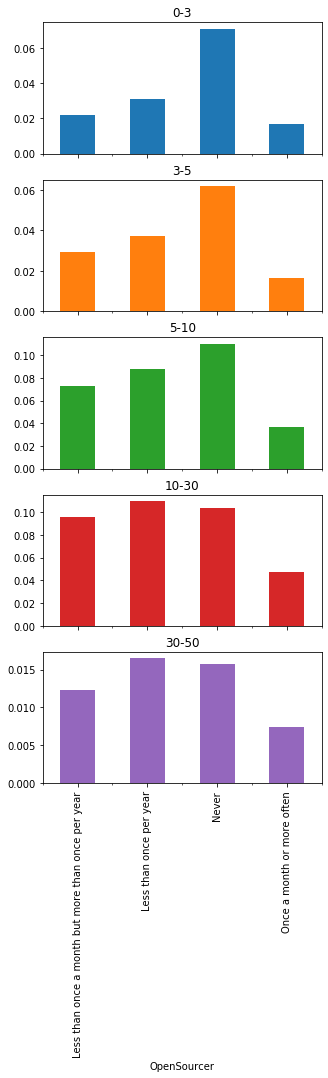

In [0]:
survey2019['YearsCode_bin'] = pd.cut(survey2019['YearsCode_cleaned'],[0,3,5,10,30,50],labels=['0-3','3-5','5-10','10-30','30-50'])
coding_ops_ = survey2019.groupby(['YearsCode_bin','OpenSourcer'])['Respondent'].count()

coding_ops_perc_ = coding_ops_.div(coding_ops_.sum())
_ = coding_ops_perc_.unstack(level=0).plot(kind='bar', subplots = True,figsize=(5,14),legend = False)